# Exercise 2: 

### Discretization of differential operators

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from mip.display.image import show, read, subplot_images
from typing import List, Optional, Tuple

In [44]:
def grad(I: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the gradient of an image I.
    --------
    Parameters:
    I: np.ndarray
    --------
    Returns:
    grad_x: np.ndarray    
    """
    M, N = I.shape
    G = np.zeros((M, N, 2))
    G[:, 1:, 0] = I[:, 1:] - I[:, :-1]
    G[:, 0, 0] = I[:, 0] 
    G[1:, :, 1] = I[1:, :] - I[:-1, :]
    G[0, :, 1] = I[0, :]  
    return G
    # grad_x = np.gradient(I, axis=1, edge_order=1)
    # grad_y = np.gradient(I, axis=0, edge_order=1)
    
    # # grad_image = np.zeros((I.shape[0], I.shape[1], 2))
    # # grad_image[:, :, 0] = grad_x
    # # grad_image[:, :, 1] = grad_y    
    # grad_image = np.stack((grad_x, grad_y), axis=-1)
    # return grad_image

grad(np.random.randint(0, 255, (100, 100))).shape

(100, 100, 2)

In [45]:
def div(G: np.ndarray) -> np.ndarray:
    """
    Computes the divergence of the gradient.
    --------
    Parameters:
    grad_x: np.ndarray
    grad_y: np.ndarray
    --------
    Returns:
    div: np.ndarray    
    """
    # div = np.gradient(G[:, :, 0], axis=1, edge_order=1) + np.gradient(G[:, :, 1], axis=0, edge_order=1)
    # return div
    M, N, _ = G.shape
    p = np.zeros((M, N))
    p[:, :-1] += G[:, :-1, 0]
    p[:, 1:] -= G[:, :-1, 0]
    p[:, 0] = -G[:, 0, 0]
    p[:-1, :] += G[:-1, :, 1]
    p[1:, :] -= G[:-1, :, 1]
    p[0, :] = -G[0, :, 1]
    return p


div(np.random.randint(0, 255, (100, 100, 2)))

array([[ -45.,  -41., -200., ..., -139., -218.,  -29.],
       [   7.,   50., -119., ...,  -49.,   26., -147.],
       [-232., -138.,  219., ...,  243., -160., -133.],
       ...,
       [ -57., -262.,  -83., ...,  167.,   -8., -220.],
       [-195.,  236.,  116., ...,  144.,  -41.,  -94.],
       [-209.,  -66., -220., ..., -269.,  -88., -108.]])

In [46]:
def laplacian(I: np.ndarray) -> np.ndarray:
    """
    Computes the laplacian of an image I.
    --------
    Parameters:
    I: np.ndarray
    --------
    Returns:
    lap: np.ndarray
    """
    lap = div(grad(I))
    return lap

laplacian(np.random.randint(0, 255, (100, 100)))

array([[ -40., -196.,  -13., ..., -122., -210., -141.],
       [ -80., -306.,   38., ..., -406.,   70., -296.],
       [-328., -282., -353., ...,  279., -296.,   -2.],
       ...,
       [ 137.,   37.,  323., ...,  117., -139.,  139.],
       [-106.,  -23., -429., ...,  205., -504.,    7.],
       [-286., -344.,  175., ...,   65.,   63.,   46.]])

Gradient: (256, 256, 2)
Divergence: (256, 256)
Laplacian: (256, 256)


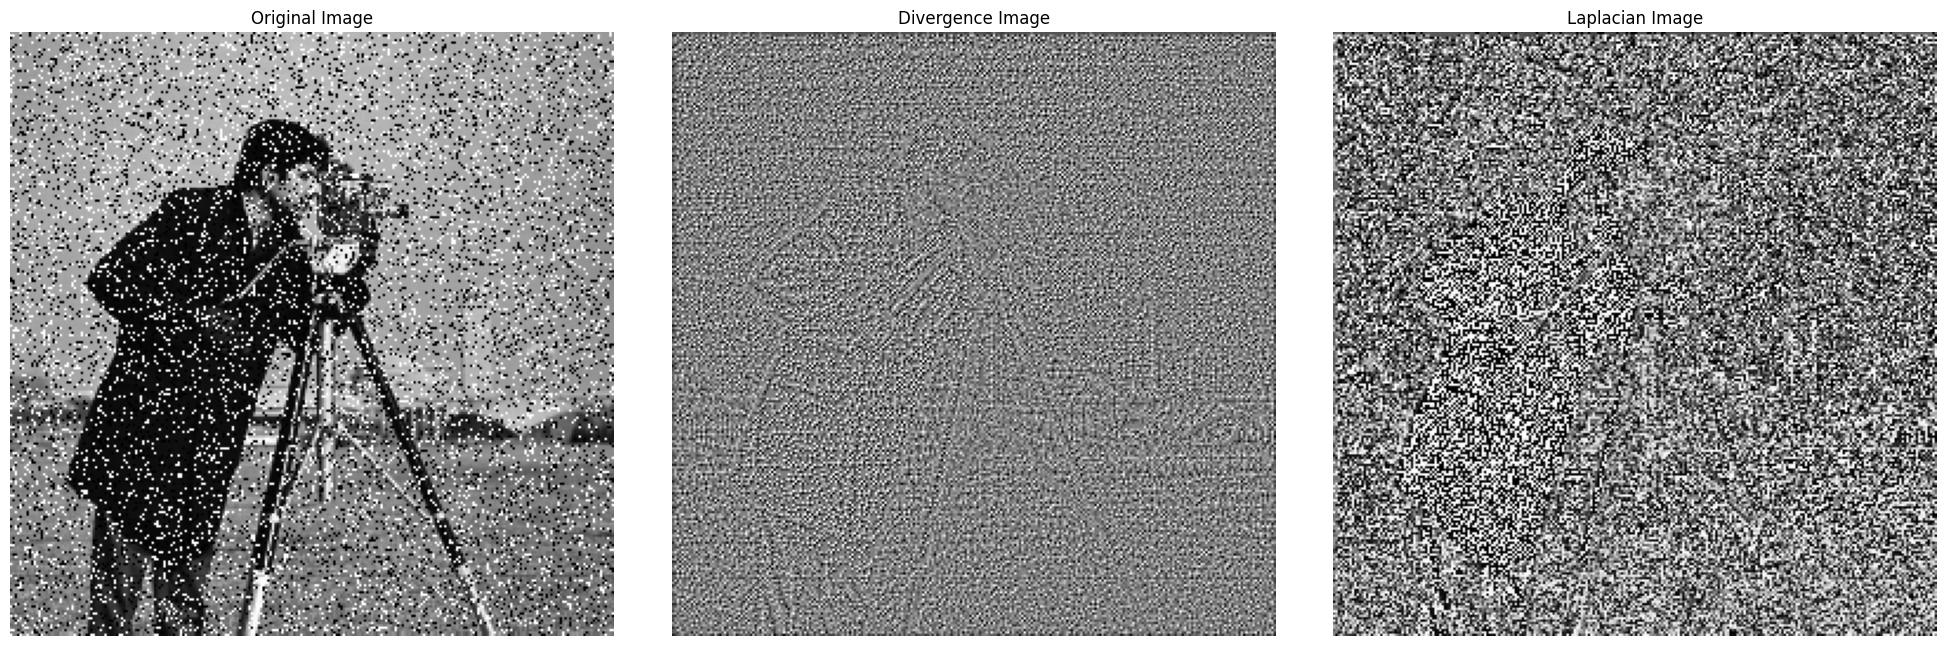

In [47]:
img = read(r"../assets/cameraman_sp.png", 'GRAY')
g = grad(img)
d = div(g)
l = laplacian(img)
print(f'Gradient: {g.shape}\nDivergence: {d.shape}\nLaplacian: {l.shape}')

subplot_images([img, d, l.astype(np.uint8)], titles=['Original Image', 
                                    'Divergence Image', 
                                    'Laplacian Image'])
plt.show()

In [65]:
def subplot_images(images: List[np.ndarray],
                   titles: Optional[List[str]] = None, fig_size: tuple = (20, 10), dpi=100,
                   cmap: str = 'gray', order: Tuple[int, int] = (1, -1)):
    """
    Subplot multiple images using matplotlib.
    """
    order = (order[0], len(images) // order[0]) if order[1] == -1 else \
            (len(images) // order[1], order[1]) if order[0] == -1 else order
    # print(order)
    fig, axes = plt.subplots(order[0], order[1], figsize=fig_size, dpi=dpi)
    # plt.subplots_adjust(wspace=0, hspace=0.1)  # Adjust the spacing between subplots
    plt.tight_layout()
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')
            if titles:
                ax.set_title(titles[i], fontsize=12)
        else:
            ax.axis('off')  # Turn off axes for empty subplots

    plt.show()
    return fig

### Iterative gradient descent scheme

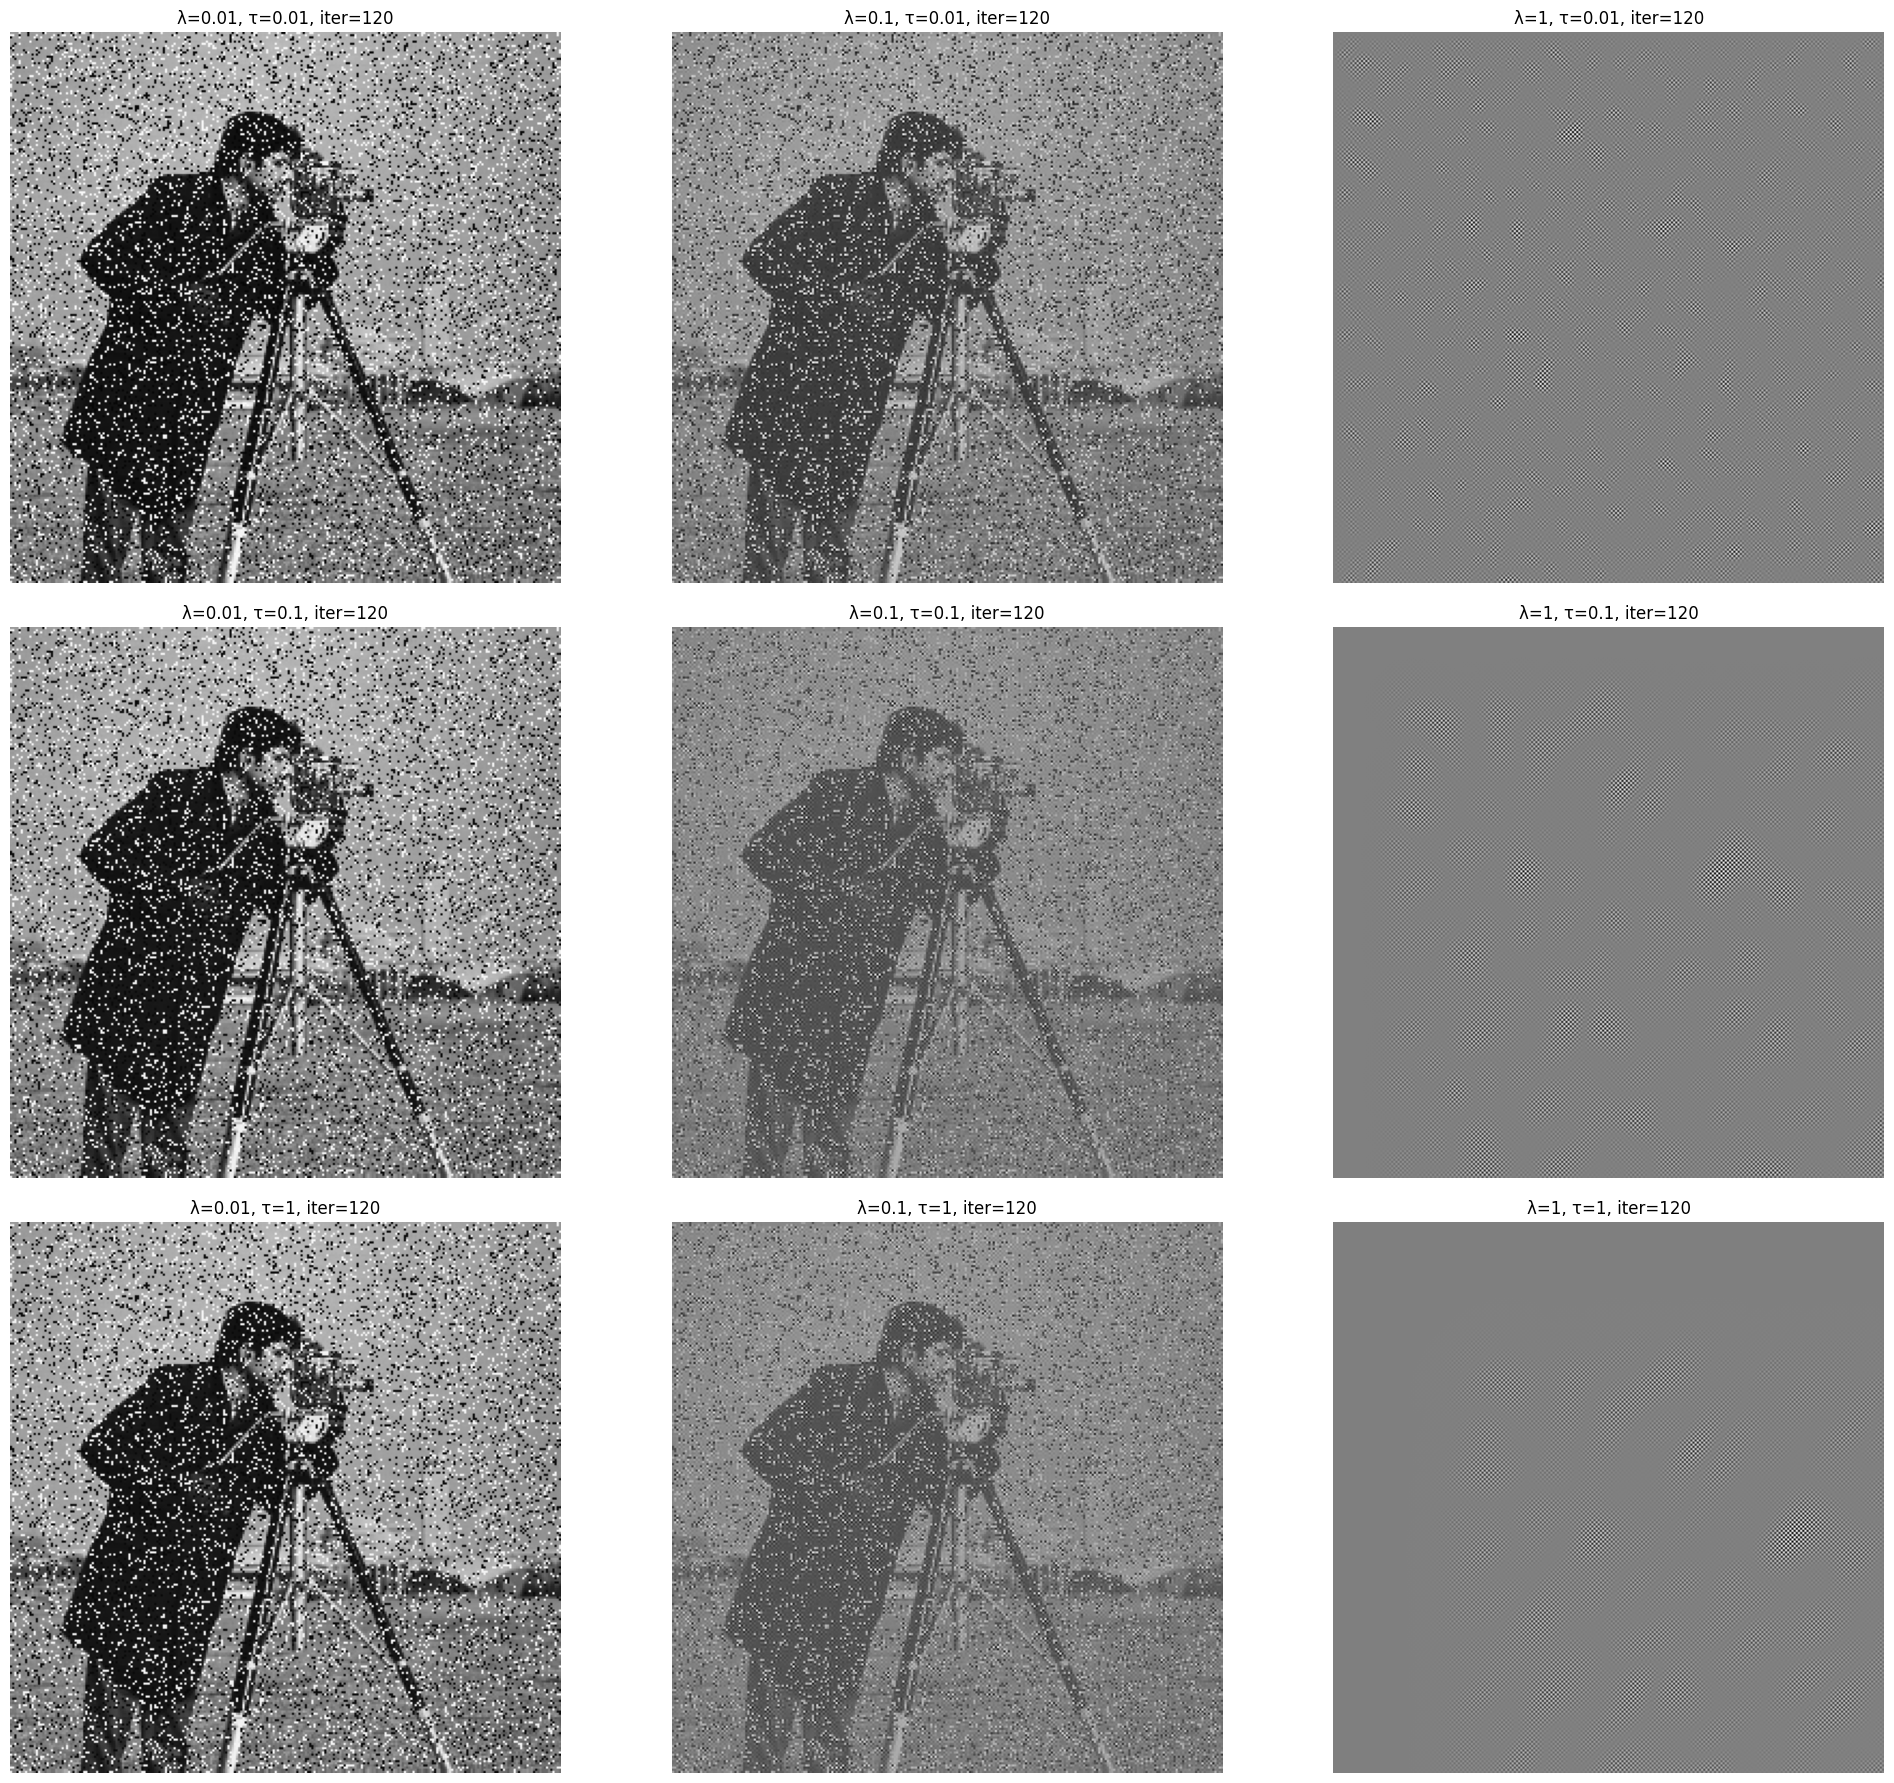

In [66]:
def tykohonov_gradient(I: np.ndarray, lambda_: float, noisy_image: np.ndarray = None, tau: float = 0.1) -> np.ndarray:
    """
    Computes the Tykohonov gradient of an image I.
    --------
    Parameters:
    I: np.ndarray
    lambda_: float
    noisy_image: np.ndarray
    tau: float
    --------
    Returns:
    tyk: np.ndarray
    """
    if noisy_image is None:
        noisy_image = I.copy()
    
    J_prime = I - noisy_image - lambda_ * laplacian(I)
    tyk = I - tau * J_prime 
    return tyk

images = []
timg = img.copy()
taus = [0.01, 0.1, 1]
lambdas = [0.01, 0.1, 1]

titles = []
iterations = 120
every = 120
for tau in taus:
    for lambda_ in lambdas:
        for i in range(iterations+1):
            timg = tykohonov_gradient(timg, lambda_, img, tau)
            if i>0 and i % every == 0:
                images.append(timg)
                titles.append(f'λ={lambda_}, τ={tau}, iter={i}')

subplot_images(images, titles=titles, fig_size=(20,18), order=(-1, 3), dpi=100).savefig('tykohonov.png')